In [1]:
#| code-summary: Load Packages
#| code-fold: true

# numerical calculation & data frames
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

# statistics
import statsmodels.api as sm


In [2]:
#| echo: false
from IPython.display import display
pd.options.display.notebook_repr_html = False

In [3]:
#| code-summary: Options
#| code-fold: true

# pandas options
pd.set_option("mode.copy_on_write", True)
pd.options.display.precision = 2
pd.options.display.float_format = '{:.2f}'.format  # pd.reset_option('display.float_format')
pd.options.display.max_rows = 7

# Numpy options
np.set_printoptions(precision = 2, suppress=True)

In [5]:
flights = pd.read_csv("../data/flights.csv")

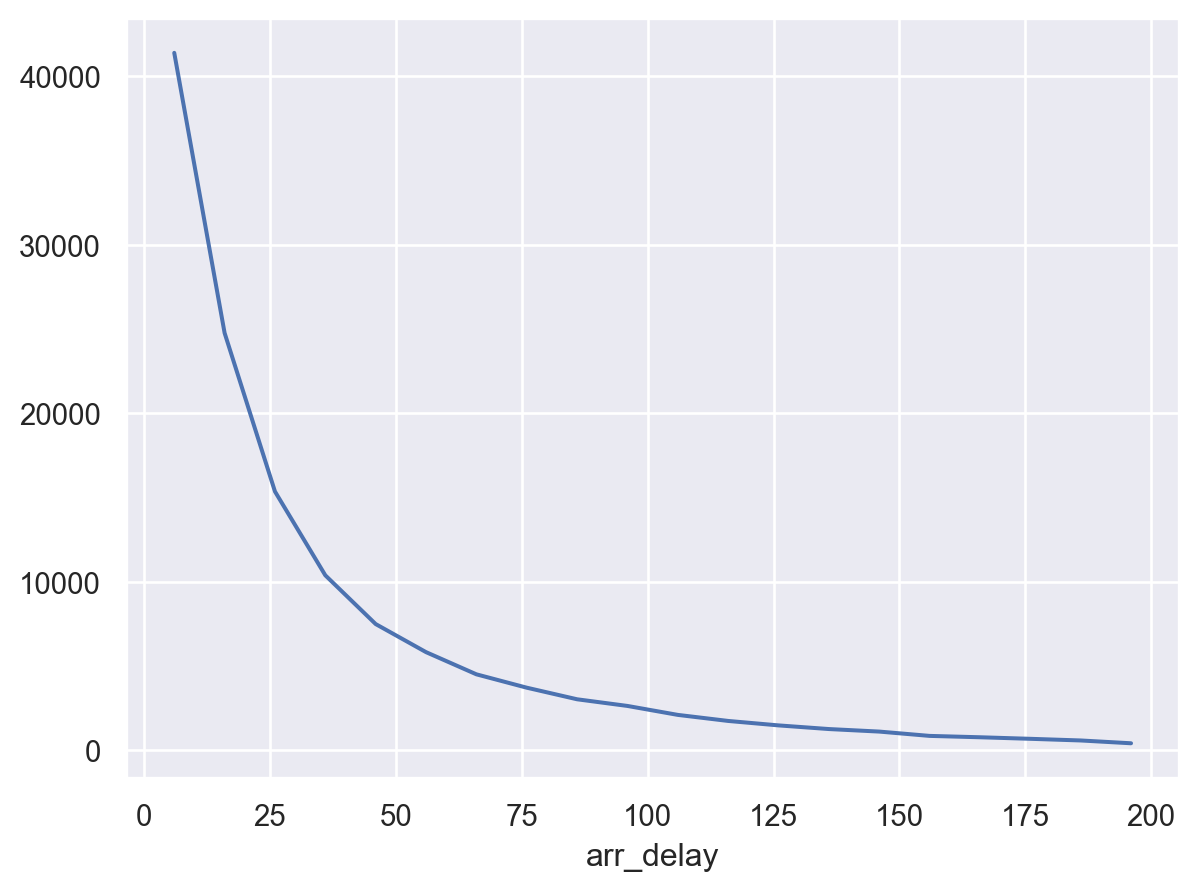

In [45]:
(
    so.Plot(flights.query('arr_delay > 0 & arr_delay < 200'), x='arr_delay')
    .add(so.Line(), so.Hist(binwidth=10))
)

In [56]:
flights.query('arr_delay > 0')['arr_delay'].quantile(.25)

8.0

In [59]:
def get_quartile_range(g):
    return (g.query('arr_delay > 0')["arr_delay"].quantile(.75) -
            g.query('arr_delay > 0')["arr_delay"].quantile(.25))  

In [66]:
iqr = flights.groupby('hour').apply(get_quartile_range).reset_index(name='IQR')
iqr

    hour   IQR
0      1   NaN
1      5 16.00
2      6 19.00
..   ...   ...
17    21 58.00
18    22 53.00
19    23 35.00

[20 rows x 2 columns]

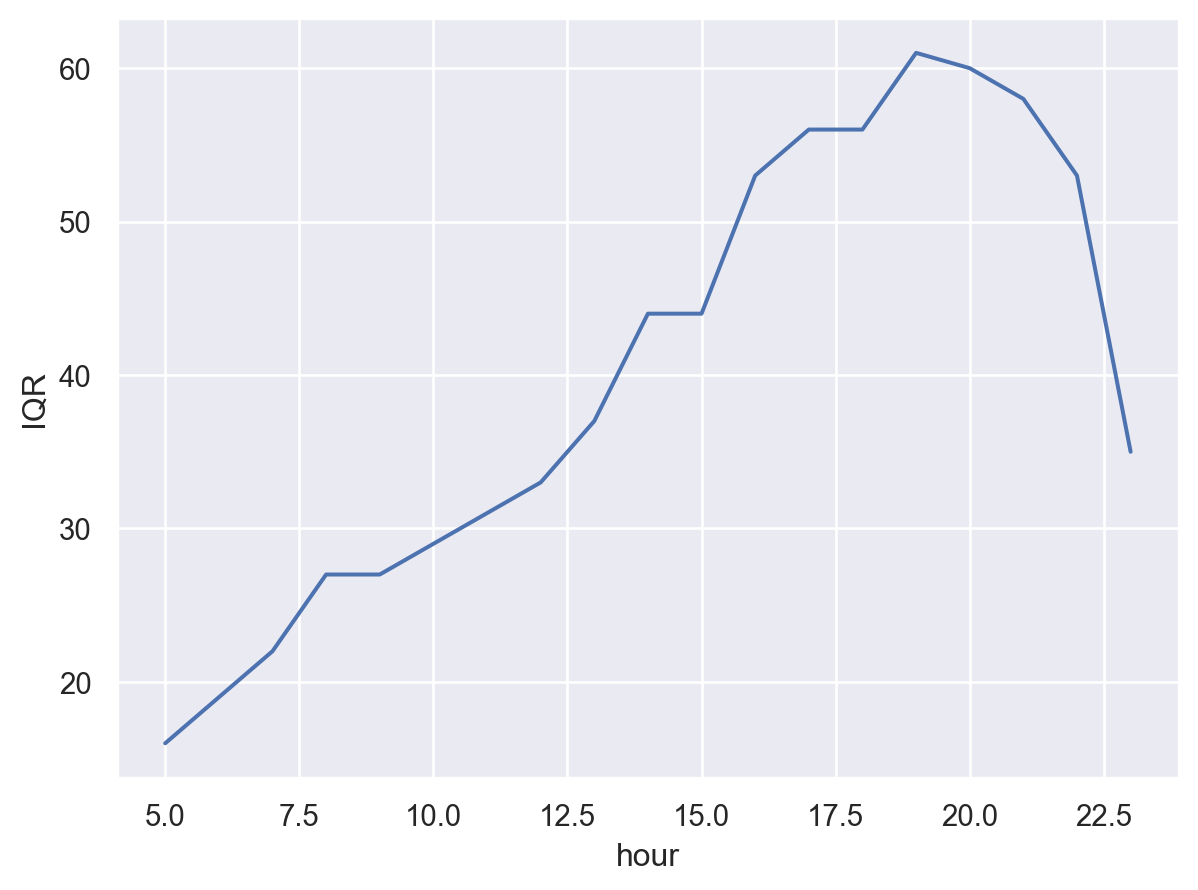

In [67]:
(
    so.Plot(iqr, x='hour', y='IQR')
    .add(so.Line())
)

In [99]:
def get_delayed_positive(g):
    return pd.Series([
        g.query('arr_delay > 0')["arr_delay"].median(),
        g.query('arr_delay > 0')["arr_delay"].count(),
        g["arr_delay"].count()
    ], index=["median_arr_delay", "n", "n_total"])

time_delay = flights.groupby(["sched_dep_time"]).apply(get_delayed_positive).fillna(0).reset_index()
time_delay

      sched_dep_time  median_arr_delay      n  n_total
0                106              0.00   0.00     0.00
1                500              7.00  73.00   340.00
2                501              0.00   0.00     1.00
...              ...               ...    ...      ...
1018            2355             12.00  36.00    73.00
1019            2358             18.00  29.00    44.00
1020            2359             18.00 413.00   810.00

[1021 rows x 4 columns]

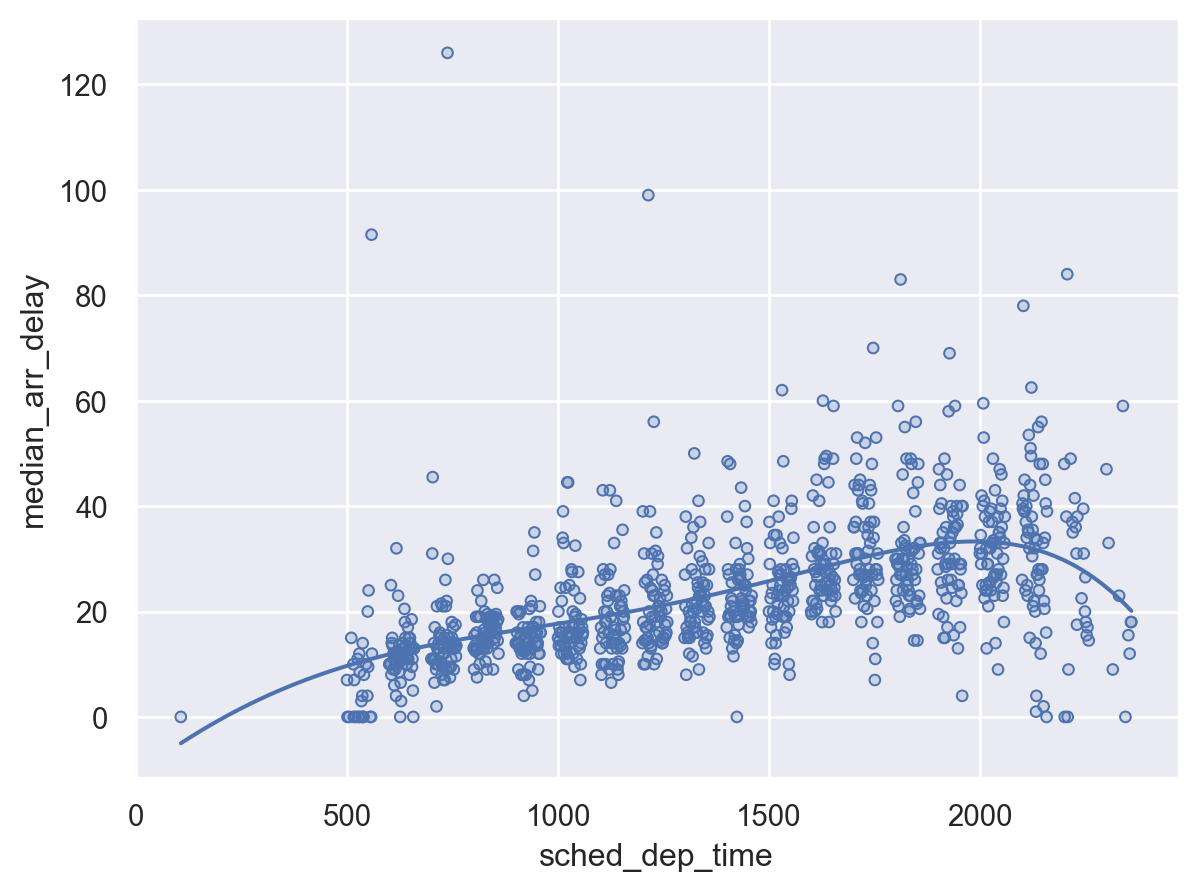

In [100]:
(
    so.Plot(time_delay, x='sched_dep_time', y='median_arr_delay')
    .add(so.Dots())
    .add(so.Line(), so.PolyFit(5))
)

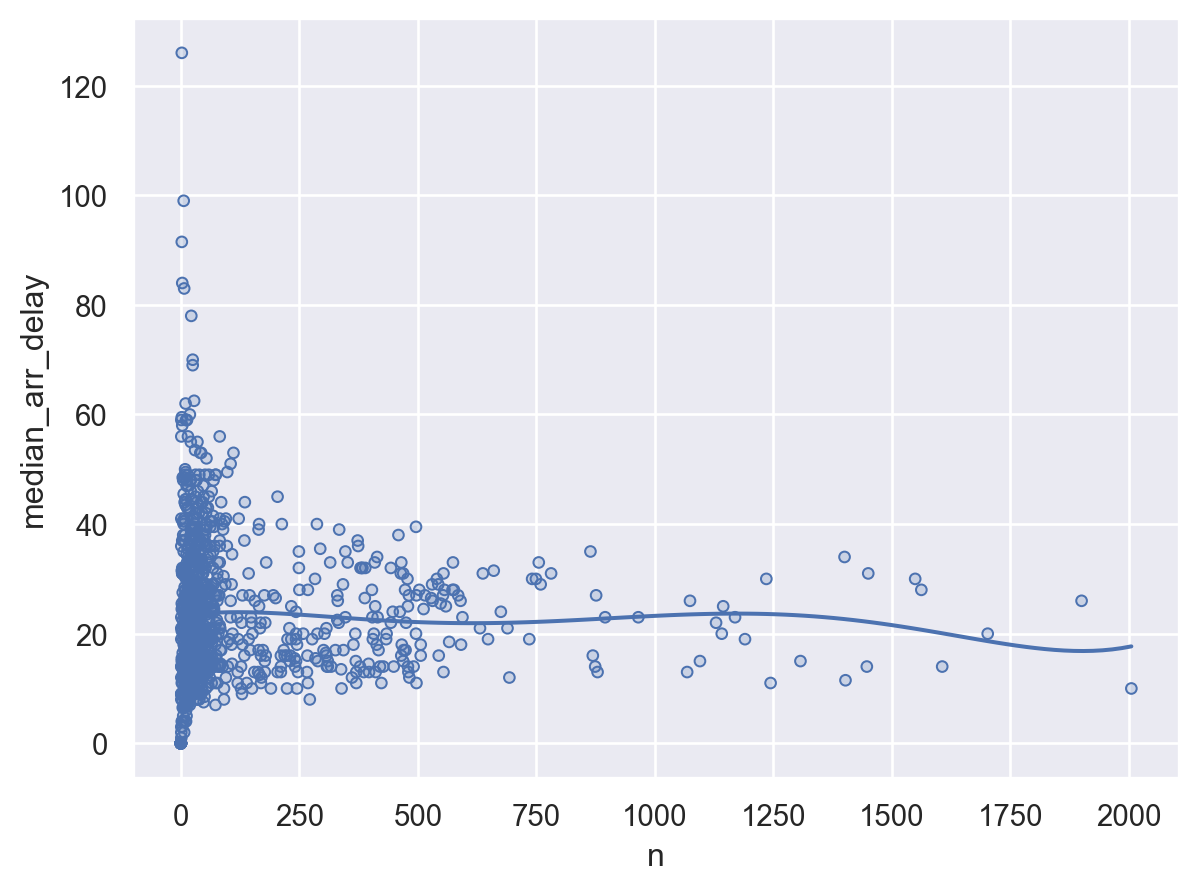

In [101]:
(
    so.Plot(time_delay, x='n', y='median_arr_delay')
    .add(so.Dots())
    .add(so.Line(), so.PolyFit(5))
)

In [8]:
import plotly.express as px

px.scatter(time_delay, x='sched_dep_time', y='median_arr_delay', trendline="lowess")

In [102]:
time_delay.sort_values(by="median_arr_delay", ascending=False).head(5)

     sched_dep_time  median_arr_delay    n  n_total
128             738            126.00 2.00    15.00
404            1214             99.00 6.00    52.00
28              558             91.50 2.00     3.00
991            2207             84.00 3.00     3.00
762            1812             83.00 7.00    14.00

In [10]:
pd.options.display.max_rows = 0

In [103]:
time_delay.assign(prop = lambda x: x.n / x.n_total).query('n_total > 20').sort_values(by="prop", ascending=False).head(10)

      sched_dep_time  median_arr_delay     n  n_total  prop
1001            2231             38.00 51.00    61.00  0.84
942             2112             25.00 29.00    35.00  0.83
737             1747             70.00 25.00    31.00  0.81
...              ...               ...   ...      ...   ...
966             2136             33.50 44.00    59.00  0.75
729             1739             44.00 46.00    62.00  0.74
816             1906             44.00 34.00    46.00  0.74

[10 rows x 5 columns]

In [104]:
hourly_delay = flights.groupby(["hour"]).apply(get_delayed_positive).fillna(0).reset_index()
hourly_delay

    hour  median_arr_delay       n  n_total
0      1              0.00    0.00     0.00
1      5             10.00  563.00  1940.00
2      6             11.00 7484.00 25447.00
..   ...               ...     ...      ...
17    21             33.00 5507.00 10503.00
18    22             31.00 1257.00  2558.00
19    23             19.00  542.00  1042.00

[20 rows x 4 columns]

In [105]:
hourly_delay = hourly_delay.assign(prop = lambda x: x.n / x.n_total).sort_values(by="prop", ascending=False)
hourly_delay

    hour  median_arr_delay       n  n_total  prop
17    21             33.00 5507.00 10503.00  0.52
19    23             19.00  542.00  1042.00  0.52
16    20             32.00 7996.00 16061.00  0.50
..   ...               ...     ...      ...   ...
1      5             10.00  563.00  1940.00  0.29
3      7             12.00 6113.00 22475.00  0.27
0      1              0.00    0.00     0.00   NaN

[20 rows x 5 columns]

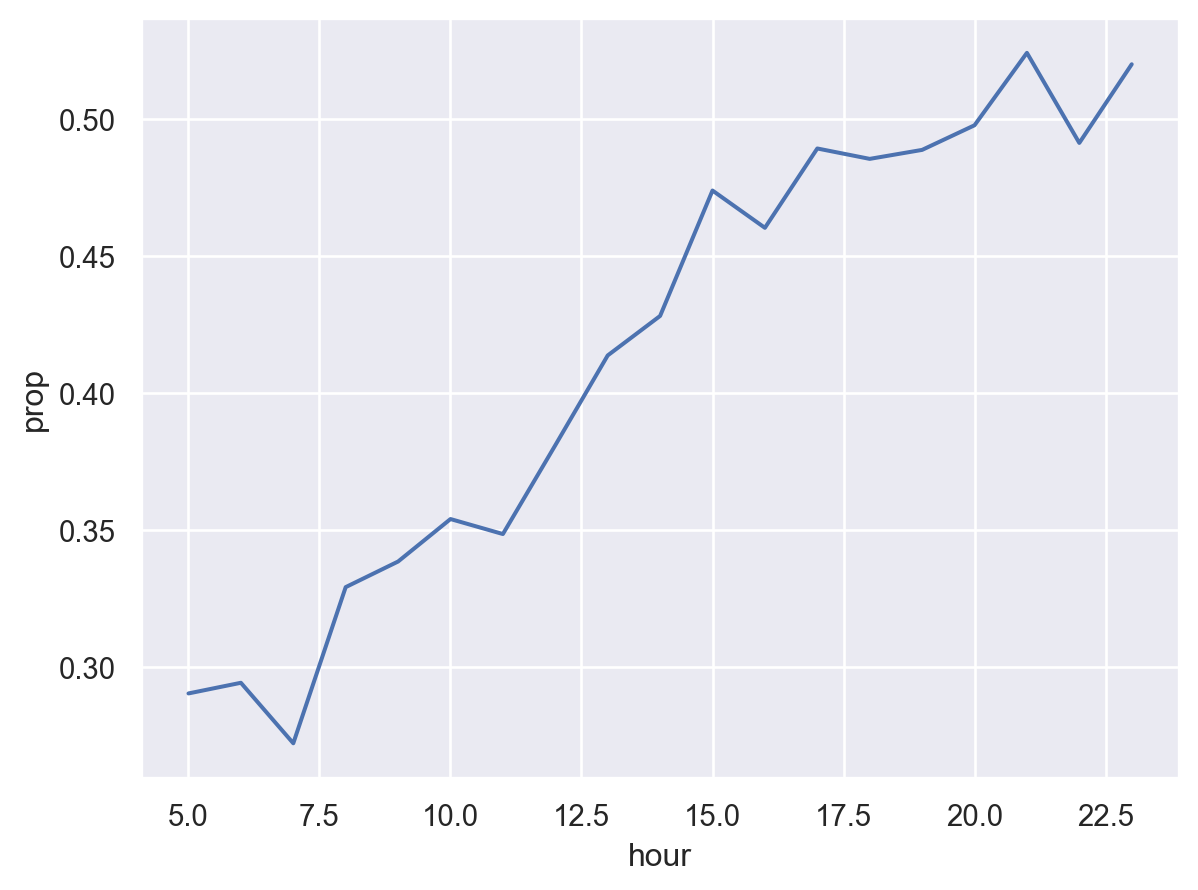

In [106]:
(
    so.Plot(hourly_delay, x='hour', y='prop')
    .add(so.Line())
)

In [107]:
hourly_delay = flights.groupby(["origin", "hour"]).apply(get_delayed_positive).fillna(0).reset_index()
hourly_delay = hourly_delay.assign(prop = lambda x: x.n / x.n_total).sort_values(by="prop", ascending=False)

In [108]:
hourly_delay

   origin  hour  median_arr_delay       n  n_total  prop
15    EWR    19             33.00 3309.00  5713.00  0.58
18    EWR    22             36.00   35.00    61.00  0.57
14    EWR    18             29.00 3794.00  6845.00  0.55
..    ...   ...               ...     ...      ...   ...
1     EWR     5             10.00  238.00   889.00  0.27
41    LGA     7             12.00 1793.00  6996.00  0.26
0     EWR     1              0.00    0.00     0.00   NaN

[57 rows x 6 columns]

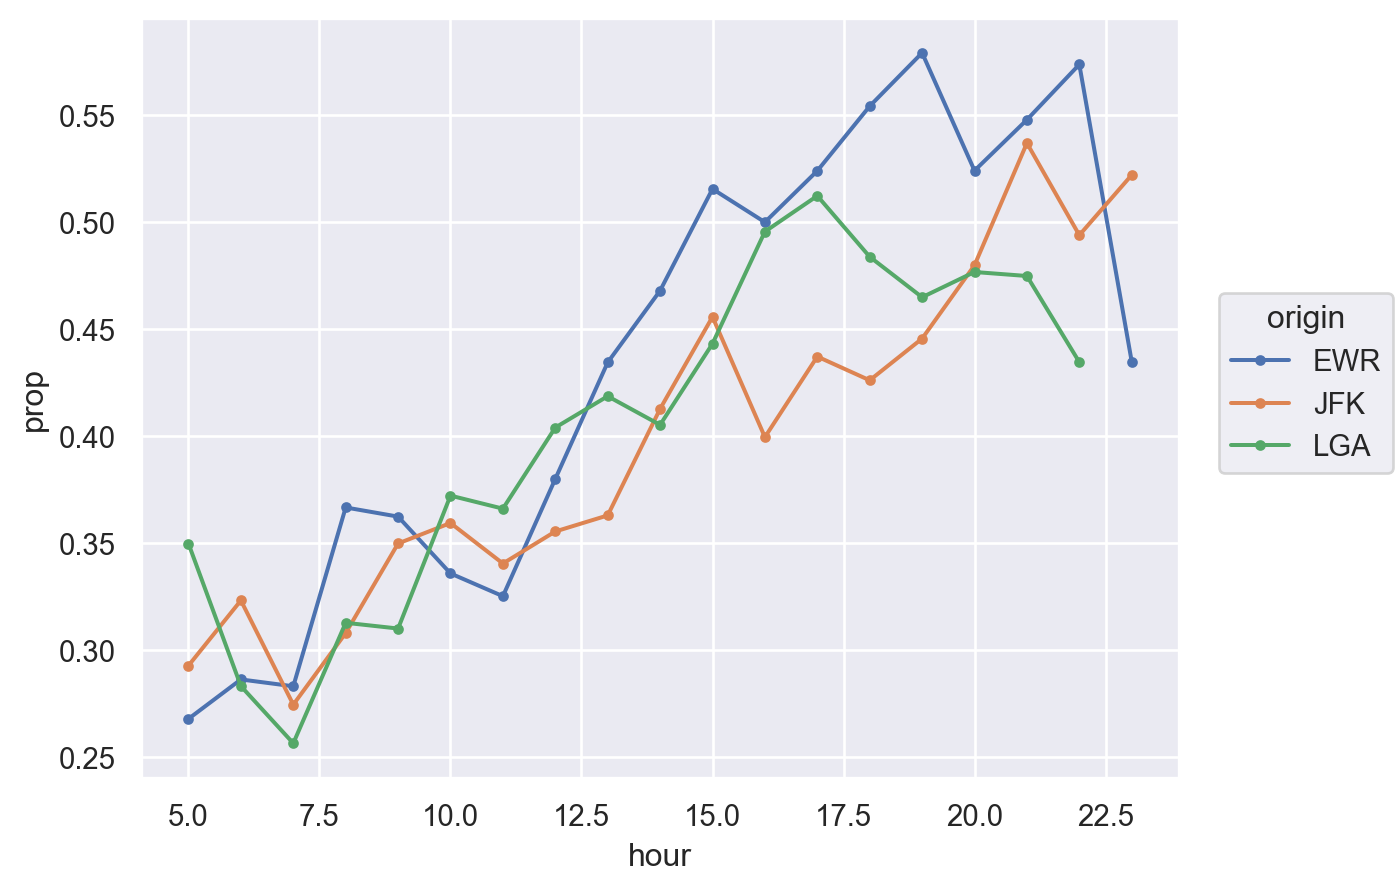

In [109]:
(
    so.Plot(hourly_delay, x='hour', y='prop', color='origin')
    .add(so.Line(marker="."))
)

세 공항에서 모두 출항하는 항공편이 존재하는 도착지들만 추려보세요.

In [21]:
origin_dest = flights.groupby(["origin", "dest"]).size().reset_index(name="n")

In [24]:
origin_dest

    origin dest     n
0      EWR  ALB   439
1      EWR  ANC     8
2      EWR  ATL  5022
..     ...  ...   ...
221    LGA  TVC    77
222    LGA  TYS   308
223    LGA  XNA   745

[224 rows x 3 columns]

In [37]:
dest_list = origin_dest.groupby("dest").size().reset_index(name="n").query('n == 3').sort_values("dest")
dest_list

    dest  n
4    ATL  3
10   BNA  3
11   BOS  3
..   ... ..
97   STL  3
99   SYR  3
100  TPA  3

[42 rows x 2 columns]

In [39]:
dest_list[dest_list["dest"].str.startswith("B")]

   dest  n
10  BNA  3
11  BOS  3
13  BTV  3
14  BUF  3
16  BWI  3

공항의 날씨를 활용

In [82]:
weather = sm.datasets.get_rdataset("weather", "nycflights13").data
weather

      origin  year  month  day  hour  temp  dewp  humid  wind_dir  wind_speed  \
0        EWR  2013      1    1     1 39.02 26.06  59.37    270.00       10.36   
1        EWR  2013      1    1     2 39.02 26.96  61.63    250.00        8.06   
2        EWR  2013      1    1     3 39.02 28.04  64.43    240.00       11.51   
...      ...   ...    ...  ...   ...   ...   ...    ...       ...         ...   
26112    LGA  2013     12   30    16 32.00 15.08  49.19    340.00       14.96   
26113    LGA  2013     12   30    17 30.92 12.92  46.74    320.00       17.26   
26114    LGA  2013     12   30    18 28.94 10.94  46.41    330.00       18.41   

       wind_gust  precip  pressure  visib            time_hour  
0            NaN    0.00   1012.00  10.00  2013-01-01 01:00:00  
1            NaN    0.00   1012.30  10.00  2013-01-01 02:00:00  
2            NaN    0.00   1012.50  10.00  2013-01-01 03:00:00  
...          ...     ...       ...    ...                  ...  
26112      23.02    0.00  

In [114]:
weather

      origin  year  month  day  hour  temp  dewp  humid  wind_dir  wind_speed  \
0        EWR  2013      1    1     1 39.02 26.06  59.37    270.00       10.36   
1        EWR  2013      1    1     2 39.02 26.96  61.63    250.00        8.06   
2        EWR  2013      1    1     3 39.02 28.04  64.43    240.00       11.51   
...      ...   ...    ...  ...   ...   ...   ...    ...       ...         ...   
26112    LGA  2013     12   30    16 32.00 15.08  49.19    340.00       14.96   
26113    LGA  2013     12   30    17 30.92 12.92  46.74    320.00       17.26   
26114    LGA  2013     12   30    18 28.94 10.94  46.41    330.00       18.41   

       wind_gust  precip  pressure  visib            time_hour  
0            NaN    0.00   1012.00  10.00  2013-01-01 01:00:00  
1            NaN    0.00   1012.30  10.00  2013-01-01 02:00:00  
2            NaN    0.00   1012.50  10.00  2013-01-01 03:00:00  
...          ...     ...       ...    ...                  ...  
26112      23.02    0.00  

In [115]:
flights_weather = pd.merge(flights, weather, left_on=["year", "month", "day", "hour", "origin"], right_on=["year", "month", "day", "hour", "origin"], how="left")

In [110]:
def get_delayed_positive2(g):
    return pd.Series([
        g.query('dep_delay > 0')["dep_delay"].median(),
        g.query('dep_delay > 0')["dep_delay"].count(),
        g["dep_delay"].count()
    ], index=["median_dep_delay", "n", "n_total"])



In [119]:
flights_weather.groupby(["origin", "hour"]).apply(get_delayed_positive2).fillna(0).reset_index()

   origin  hour  median_dep_delay       n  n_total
0     EWR     1              0.00    0.00     0.00
1     EWR     5              6.00  226.00   892.00
2     EWR     6              9.50 2808.00 10959.00
..    ...   ...               ...     ...      ...
54    LGA    20             37.00 1458.00  3245.00
55    LGA    21             39.00 1207.00  2886.00
56    LGA    22             45.00   99.00   192.00

[57 rows x 5 columns]

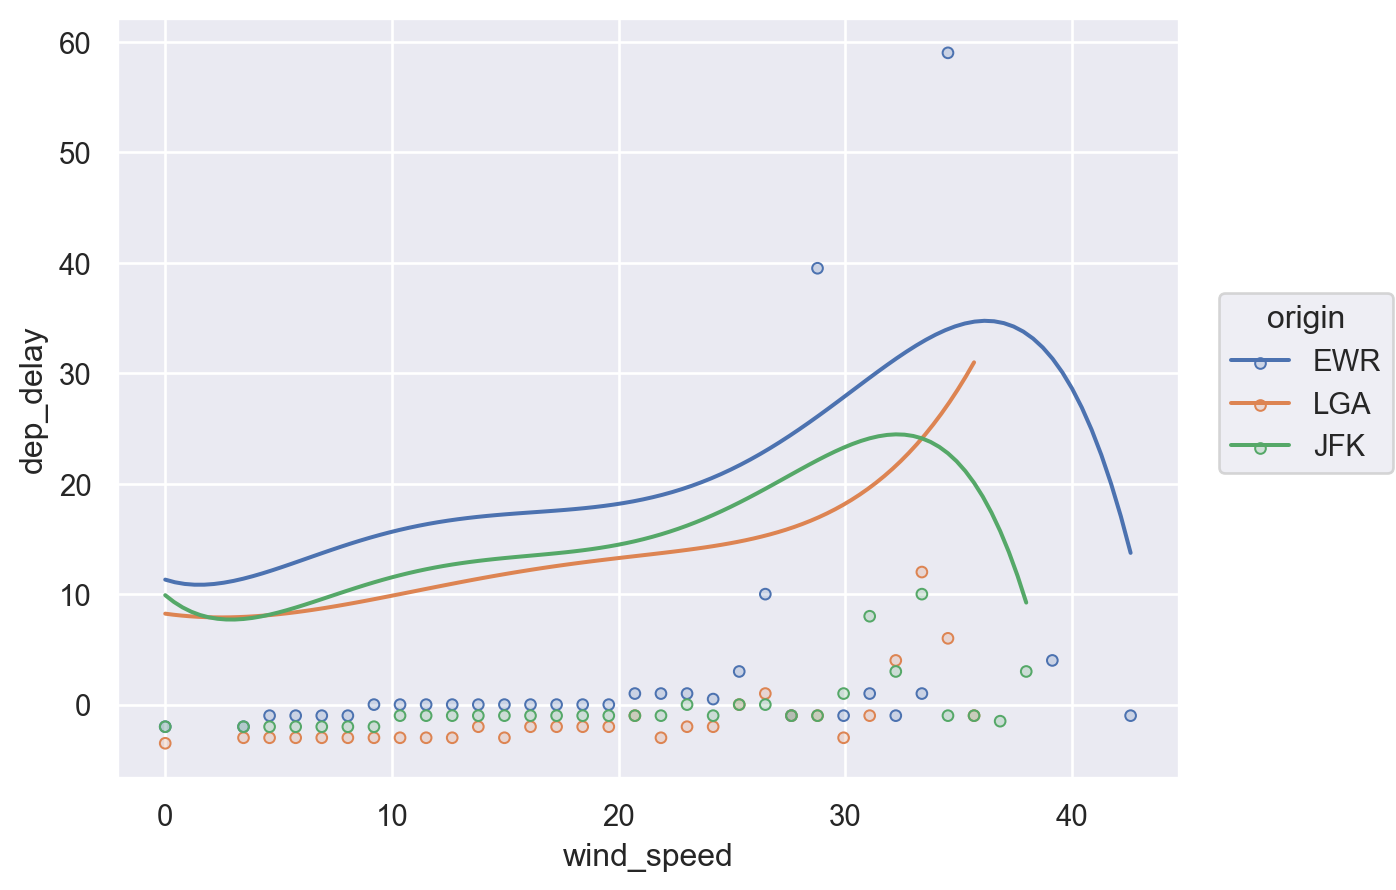

In [159]:
(
    so.Plot(flights_weather, x='wind_speed', y='dep_delay', color='origin')
    .add(so.Dots(), so.Agg("median"))
    .add(so.Line(), so.PolyFit(5))
)

<Axes: >

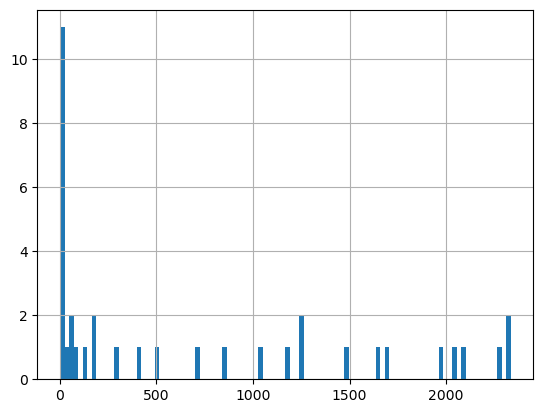

In [172]:
weather.wind_speed.value_counts().hist(bins=100)

In [178]:
flights_weather["wind_speed_cat"] = flights_weather["wind_speed"].astype("string")

In [184]:
weather.wind_speed.unique()

array([  10.36,    8.06,   11.51,   12.66,   14.96,   13.81,   16.11,
          9.21,   18.41,    6.9 ,    3.45,   17.26,    5.75,    4.6 ,
         20.71,   24.17,   21.86,    0.  ,   23.02,   19.56,   25.32,
         26.47,   28.77,   31.07,   27.62,   40.28,   42.58,   39.13,
         32.22,   33.37, 1048.36,   29.92,     nan,   34.52,   35.67,
         36.82,   37.98])

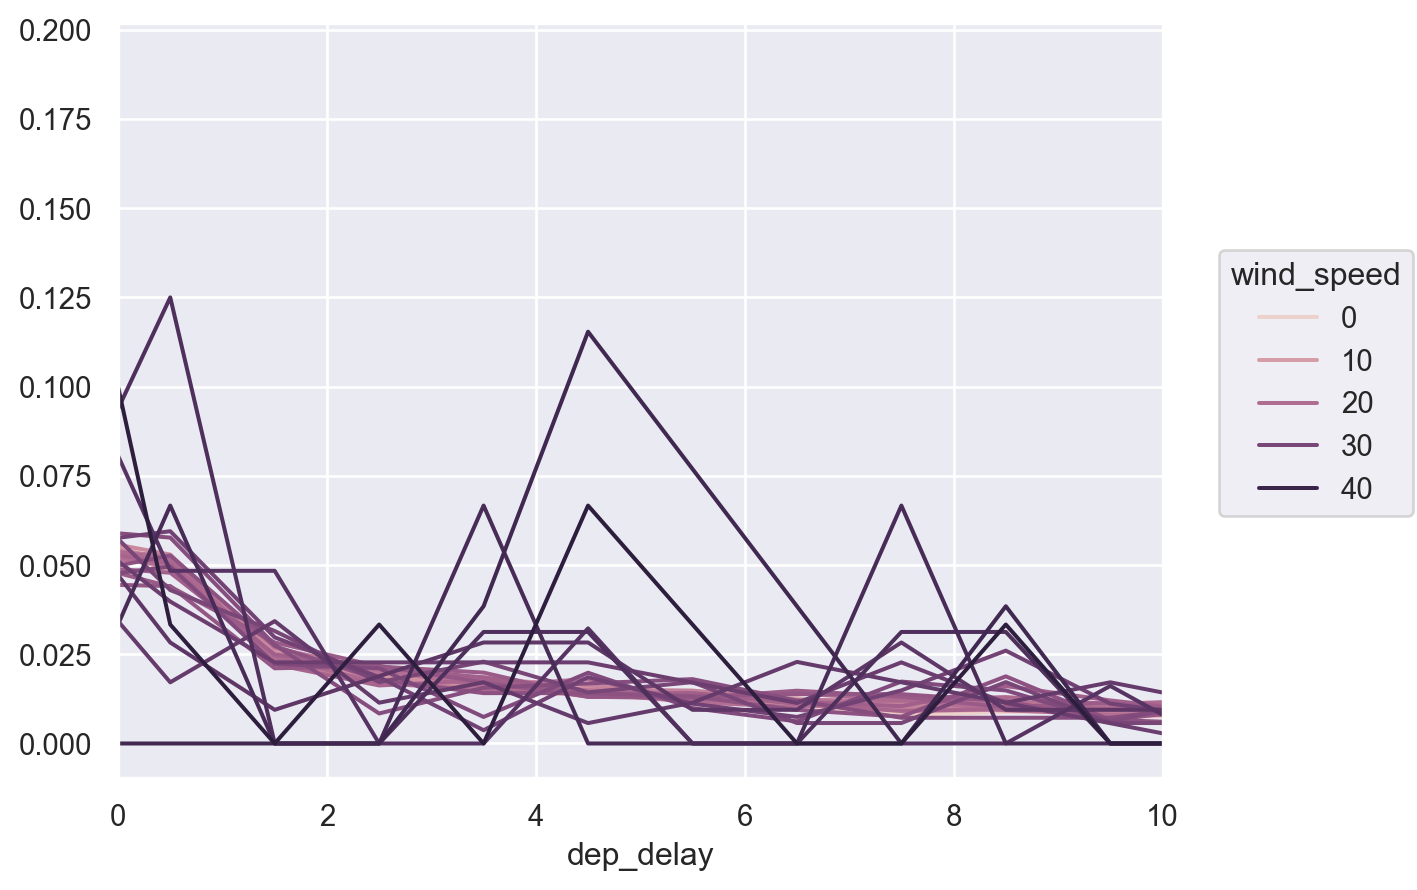

In [186]:
(
    so.Plot(flights_weather, x='dep_delay', color="wind_speed")
    .add(so.Line(), so.Hist(stat="proportion", binwidth=1, common_norm=False))
    .limit(x=(0, 10))
)

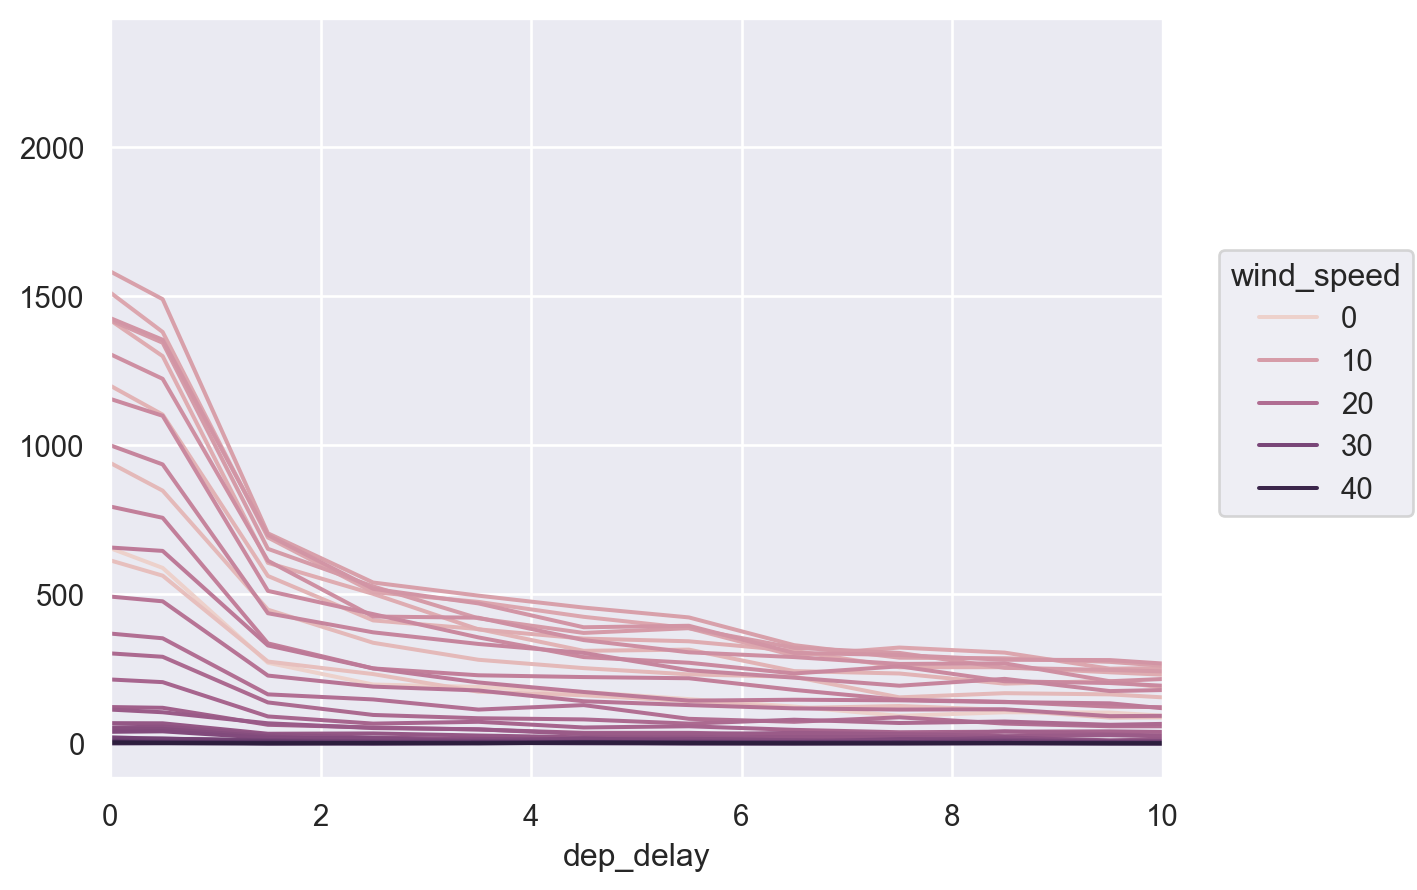

In [188]:
(
    so.Plot(flights_weather, x='dep_delay', color="wind_speed")
    .add(so.Line(), so.Hist(binwidth=1))
    .limit(x=(0, 10))
)

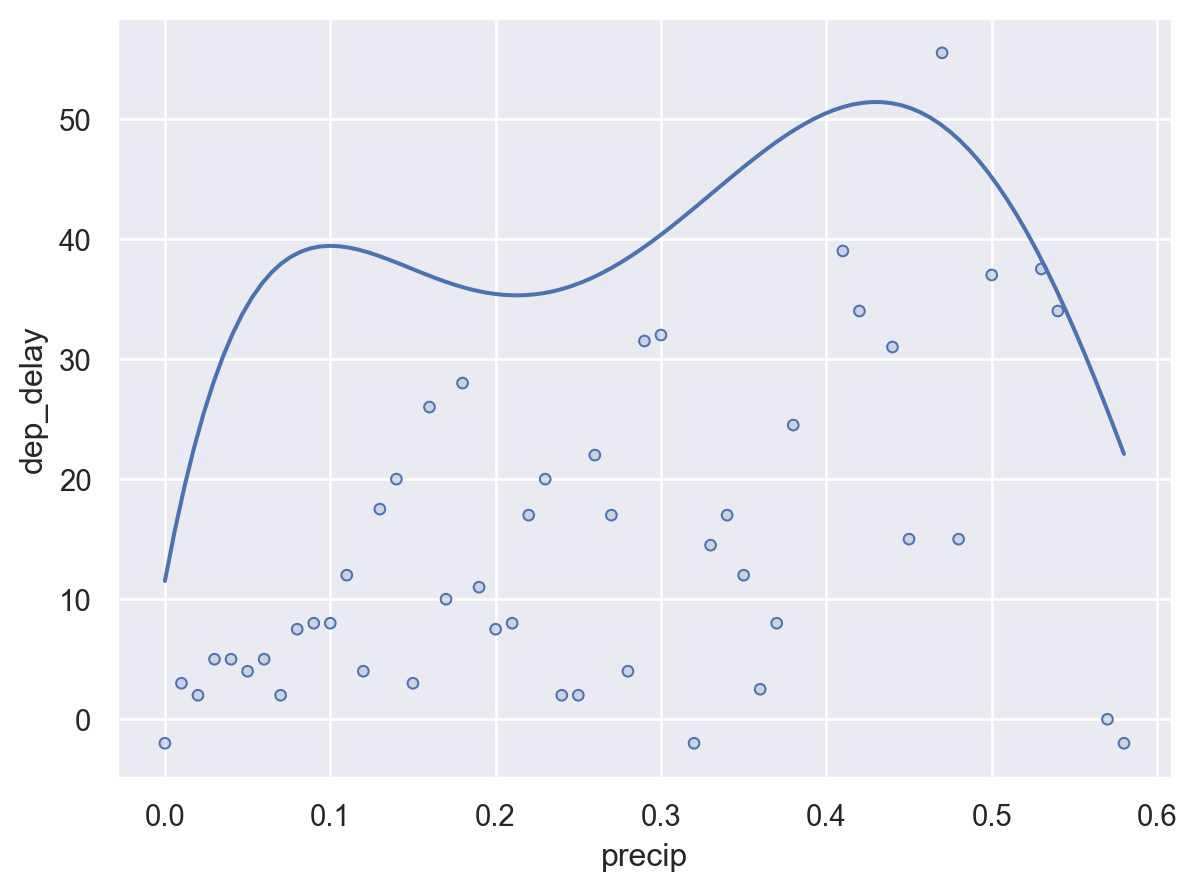

In [141]:
(
    so.Plot(flights_weather.query('precip < .6'), x='precip', y='dep_delay')
    .add(so.Dots(), so.Agg("median"))
    .add(so.Line(), so.PolyFit(5))
)

In [146]:
flights_weather.value_counts("precip", dropna=False)

precip
0.00    312218
0.01      5467
0.02      4317
         ...  
0.50         9
0.65         9
0.53         7
Name: count, Length: 56, dtype: int64

In [155]:
precip_delay = flights_weather.query('precip < .6 & dep_delay > 0').groupby("precip")["dep_delay"].agg(["mean", "median", "count"]).reset_index()

In [156]:
precip_delay

    precip  mean  median   count
0     0.00 37.60   18.00  115567
1     0.01 56.70   33.00    2861
2     0.02 49.29   28.00    2120
..     ...   ...     ...     ...
46    0.54 63.88   41.00      16
47    0.57 17.62   15.50       8
48    0.58 69.75   68.50       4

[49 rows x 4 columns]

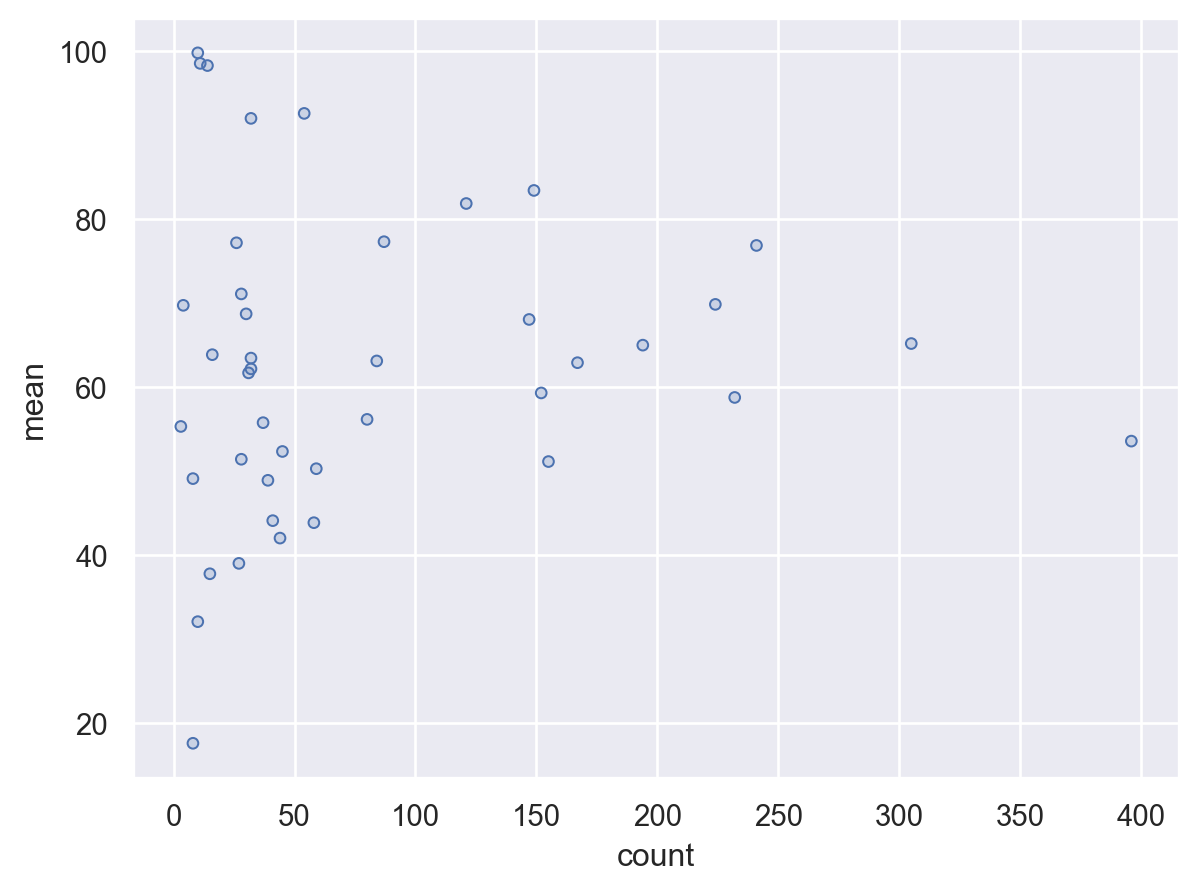

In [208]:
(
    so.Plot(precip_delay.query('precip > 0 & count < 500'), x='count', y='mean')
    .add(so.Dots())
)

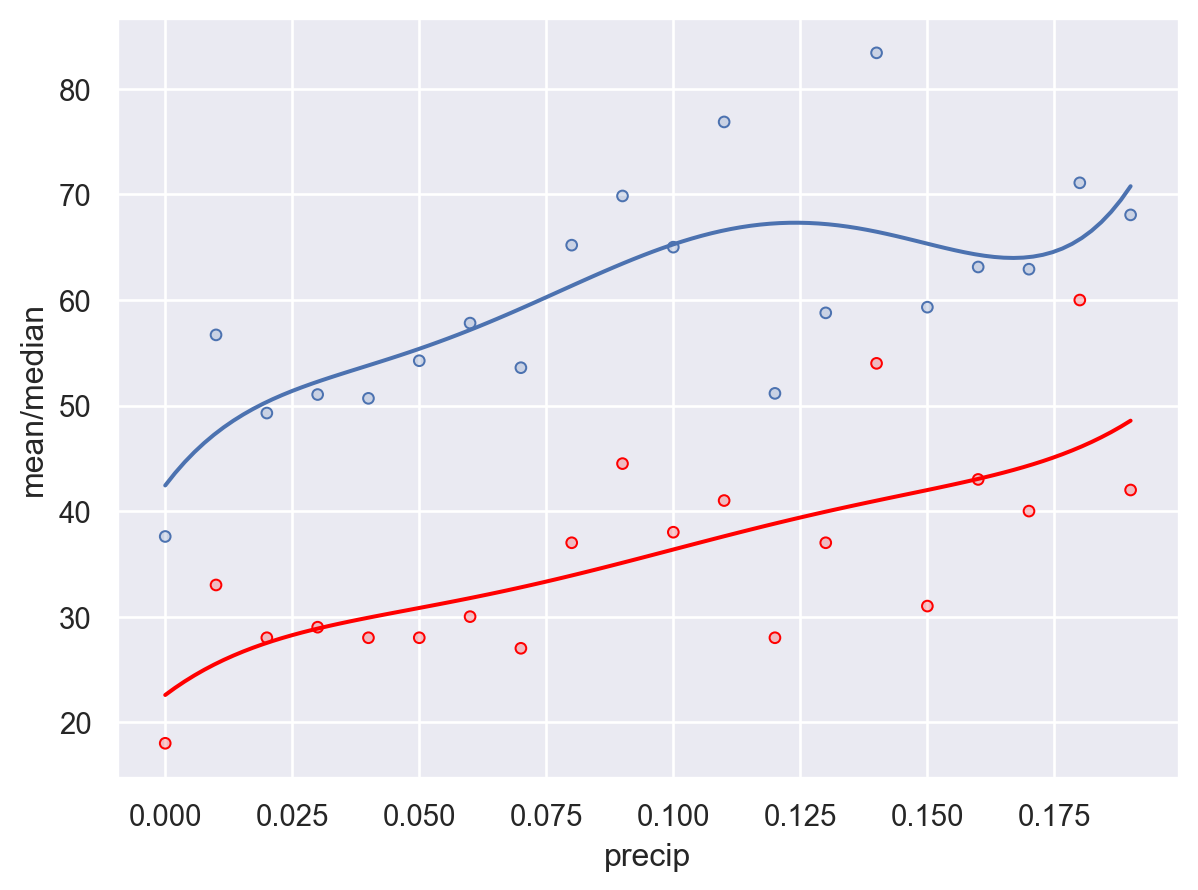

In [204]:
(
    so.Plot(precip_delay.query('precip < .2'), x='precip')
    .add(so.Dots(), y = "mean")
    .add(so.Dots(color="red"), y = "median")
    .add(so.Line(), so.PolyFit(5), y = "mean")
    .add(so.Line(color="red"), so.PolyFit(5), y = "median")
    .label(y="mean/median")
)

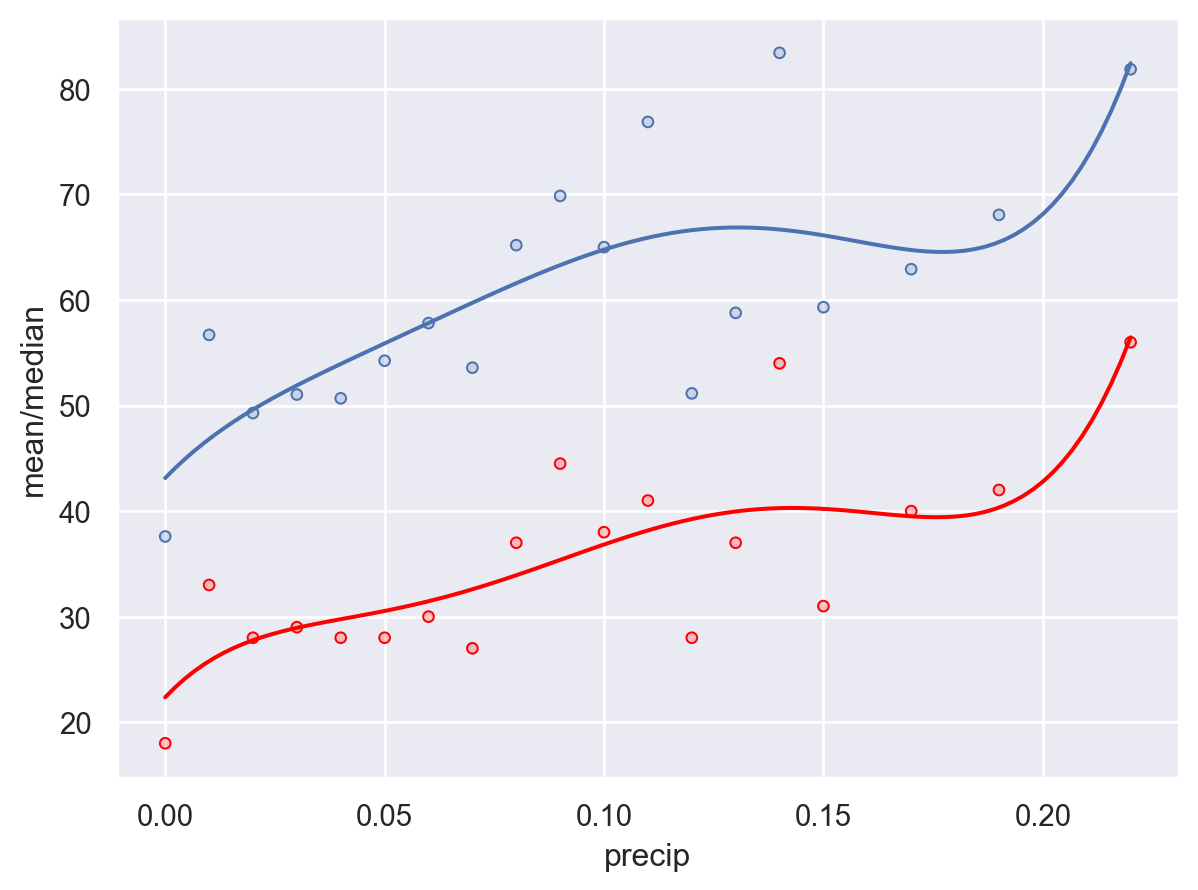

In [212]:
(
    so.Plot(precip_delay.query('count > 100'), x='precip')
    .add(so.Dots(), y = "mean")
    .add(so.Dots(color="red"), y = "median")
    .add(so.Line(), so.PolyFit(5), y = "mean")
    .add(so.Line(color="red"), so.PolyFit(5), y = "median")
    .label(y="mean/median")
)

In [214]:
flights_weather.value_counts("wind_speed", dropna=False)

wind_speed
9.21     30405
8.06     29021
11.51    27836
         ...  
42.58       31
39.13       29
37.98       18
Name: count, Length: 35, dtype: int64

In [216]:
wind_delay = flights_weather.query('dep_delay > 0').groupby("wind_speed")["dep_delay"].agg(["mean", "median", "count"]).reset_index()

In [217]:
wind_delay

    wind_speed  mean  median  count
0         0.00 39.96   17.00   3836
1         3.45 37.89   17.00   4031
2         4.60 37.36   16.00   6222
..         ...   ...     ...    ...
31       37.98 37.12   18.00      8
32       39.13 41.31   12.00     16
33       42.58 32.23   17.00     13

[34 rows x 4 columns]

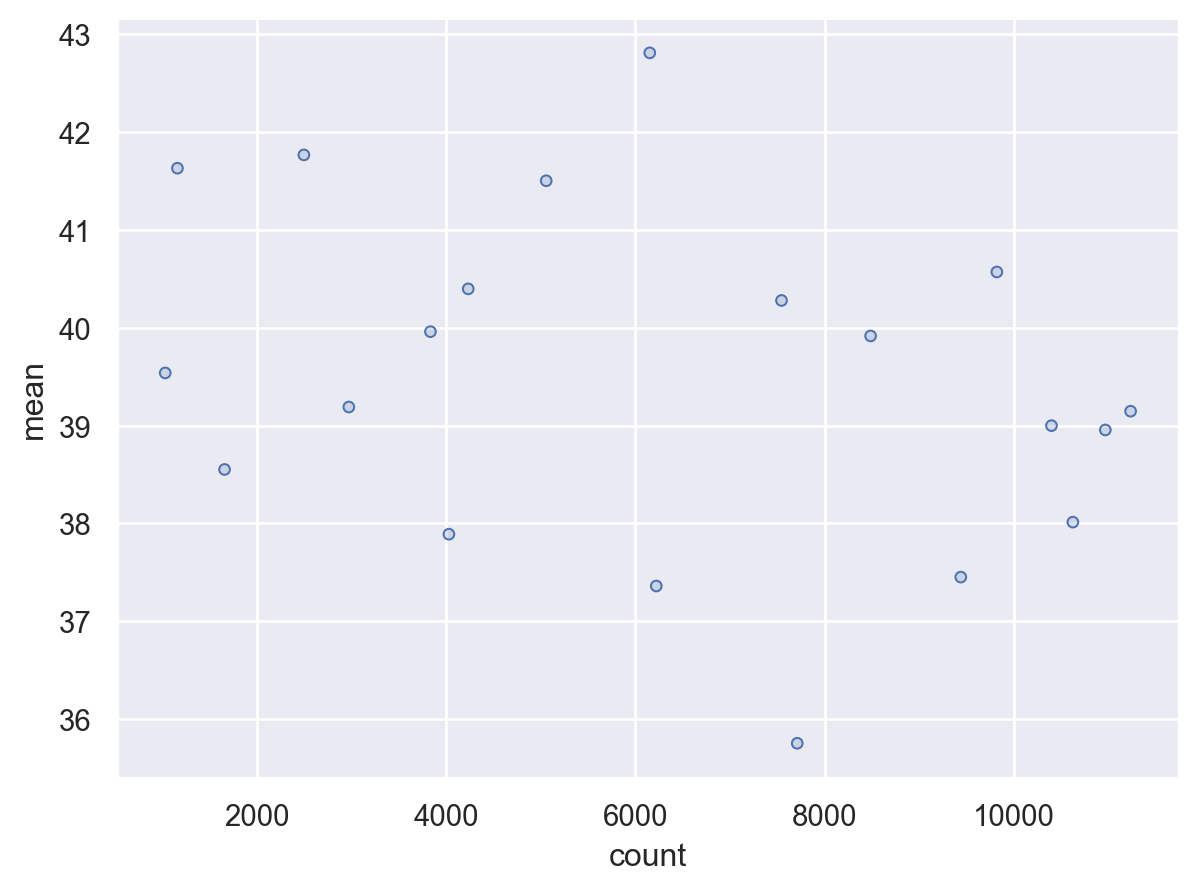

In [226]:
(
    so.Plot(wind_delay.query('count > 1000'), x='count', y='mean')
    .add(so.Dots())
)

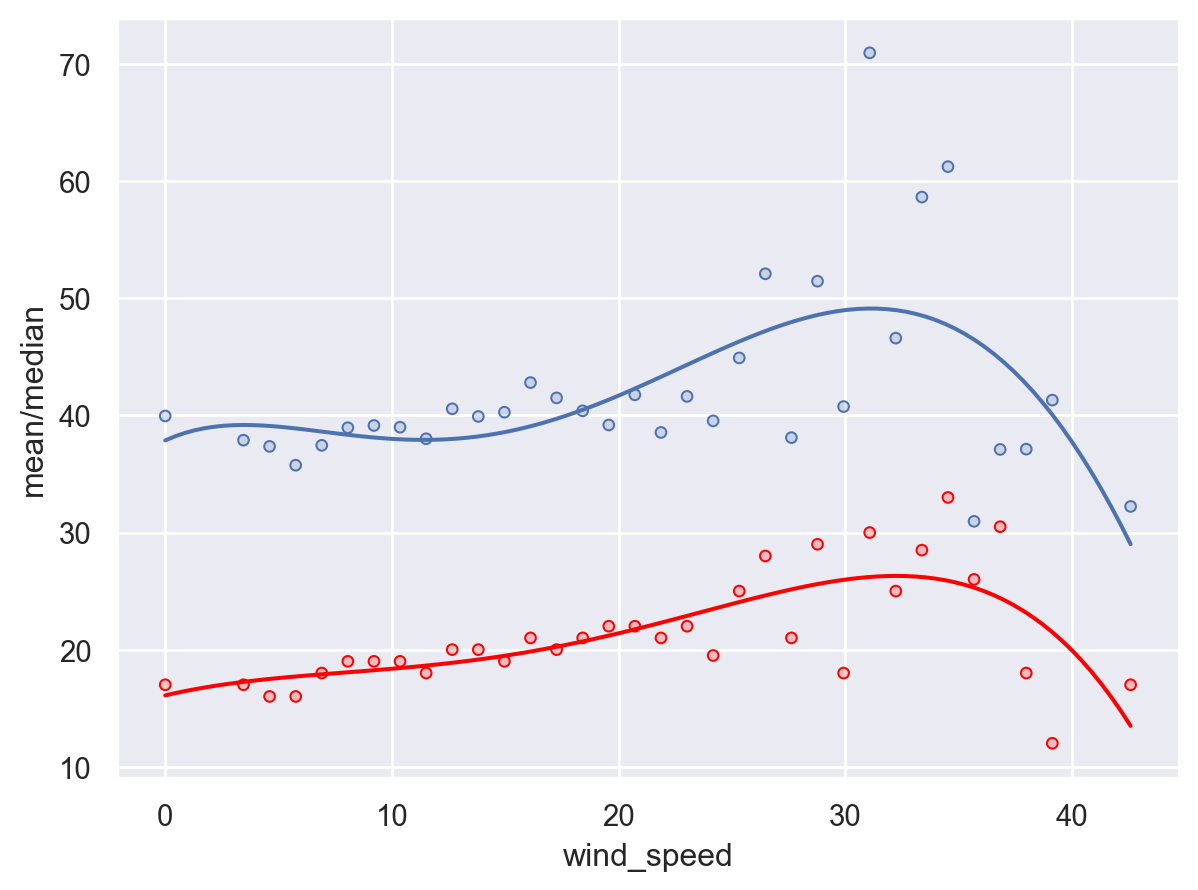

In [229]:
(
    so.Plot(wind_delay.query('count > 0'), x='wind_speed')
    .add(so.Dots(), y = "mean")
    .add(so.Dots(color="red"), y = "median")
    .add(so.Line(), so.PolyFit(5), y = "mean")
    .add(so.Line(color="red"), so.PolyFit(5), y = "median")
    .label(y="mean/median")
)

In [129]:
weather

      origin  year  month  day  hour  temp  dewp  humid  wind_dir  wind_speed  \
0        EWR  2013      1    1     1 39.02 26.06  59.37    270.00       10.36   
1        EWR  2013      1    1     2 39.02 26.96  61.63    250.00        8.06   
2        EWR  2013      1    1     3 39.02 28.04  64.43    240.00       11.51   
...      ...   ...    ...  ...   ...   ...   ...    ...       ...         ...   
26112    LGA  2013     12   30    16 32.00 15.08  49.19    340.00       14.96   
26113    LGA  2013     12   30    17 30.92 12.92  46.74    320.00       17.26   
26114    LGA  2013     12   30    18 28.94 10.94  46.41    330.00       18.41   

       wind_gust  precip  pressure  visib            time_hour  
0            NaN    0.00   1012.00  10.00  2013-01-01 01:00:00  
1            NaN    0.00   1012.30  10.00  2013-01-01 02:00:00  
2            NaN    0.00   1012.50  10.00  2013-01-01 03:00:00  
...          ...     ...       ...    ...                  ...  
26112      23.02    0.00  

Compute the air time of a flight relative to the shortest flight to that destination. Which flights were most delayed in the air?

Find the 48 hours (over the course of the whole year) that have the worst (departure) delays. Cross-reference it with the weather data. Can you see any patterns?

시간대별로 취소된 항공편의 비율을 구해보세요.

In [14]:
def get_delayed_positive(g):
    return pd.Series([
        g["cancelled"].mean(),
        g.query('dep_delay > 0')["dep_delay"].mean(),
        g.query('arr_delay > 0')["arr_delay"].mean(),
    ], index=["cancelled_prop", "avg_dep_delay", "avg_arr_delay"])

cancelled_and_delays = (
    flights.assign(
        cancelled = lambda x: x.dep_delay.isna() | x.arr_delay.isna())
    .groupby(["month", "day", "hour"])
    .apply(lambda x: x.cancelled.mean())
)

cancelled_and_delays

month  day  hour
1      1    5      0.00
            6      0.02
            7      0.00
                   ... 
12     31   21     0.00
            22     0.00
            23     0.00
Length: 6936, dtype: float64

In [25]:
cancelled_and_delays[:] = "."
cancelled_and_delays

month  day  hour
1      1    5       .
            6       .
            7       .
                   ..
12     31   21      .
            22      .
            23      .
Length: 6936, dtype: object

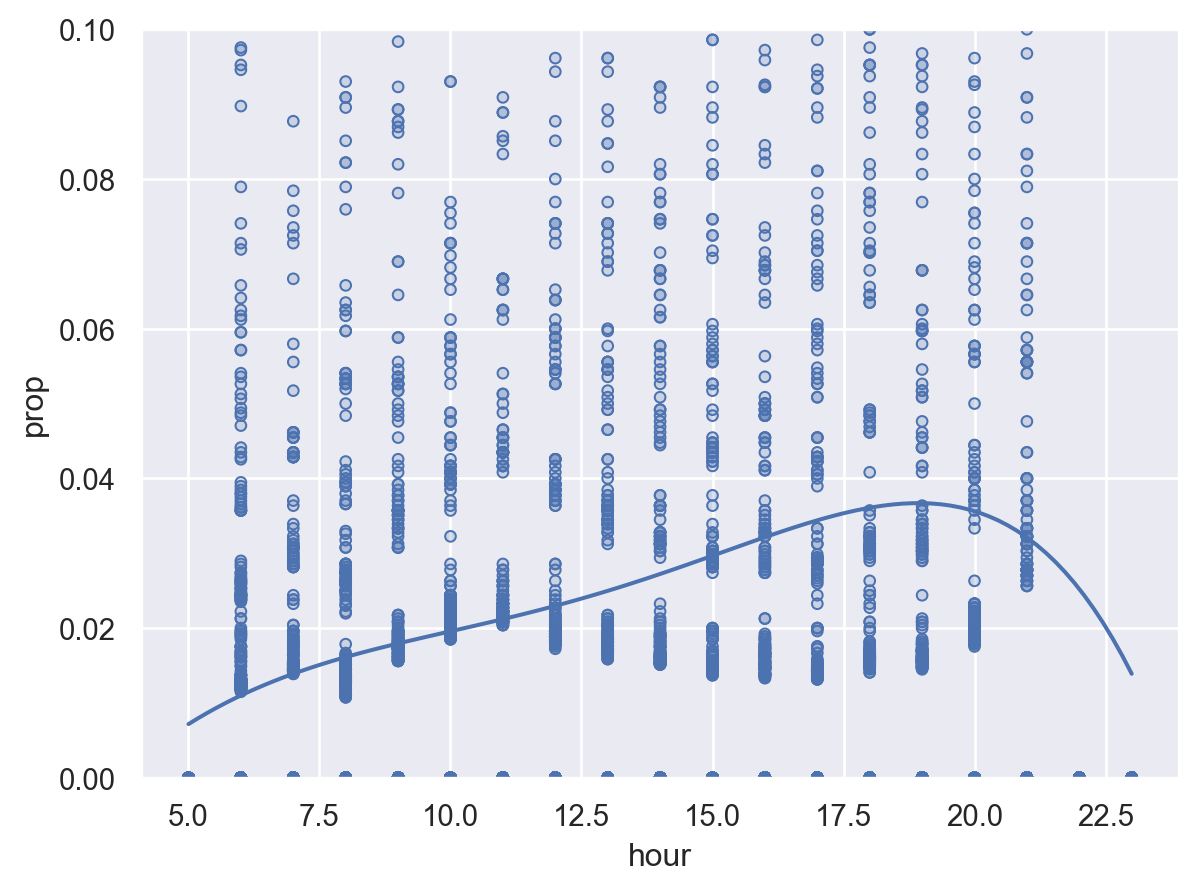

In [19]:
(
    so.Plot(cancelled_and_delays.reset_index(name="prop").query('prop < .7'), x='hour', y='prop')
    .add(so.Dots())
    .add(so.Line(), so.PolyFit(5))
    .limit(y=(0, .1))
)

하루 평균 날씨 정보와 평균 취소된 항공편 / 평균 출발지연과의 관계